In [1]:
!rm -r sample_data .config
!git clone https://github.com/saveliybabin/VRP-solver .

Cloning into '.'...
remote: Enumerating objects: 239, done.
remote: Counting objects: 100% (239/239), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 239 (delta 96), reused 219 (delta 76), pack-reused 0
Receiving objects: 100% (239/239), 5.57 MiB | 7.53 MiB/s, done.
Resolving deltas: 100% (96/96), done.


In [2]:
import requests
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import pandas as pd
from train import train_epoch_sl
from nets.nar_model_vrp import NARModel
from nets.encoders.gnn_encoder import GNNEncoder
from utils import torch_load_cpu, load_problem
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install pickle5
import pickle5 as pickle

     |████████████████████████████████| 256 kB 19.6 MB/s 


In [4]:
!pip install ortools

     |████████████████████████████████| 15.5 MB 16.2 MB/s 
     |████████████████████████████████| 1.0 MB 60.3 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


In [28]:
problem = load_problem('cvrp')

In [24]:
import pickle
with open('data/train_cvrp_v3_12800.pkl', 'rb') as f:
    train_dataset = pickle.load(f)
with open('data/val_cvrp_v5_1000.pkl', 'rb') as f:
    val_dataset = pickle.load(f)    
    

In [ ]:
# train_dataset = problem.make_dataset(
#         'data/vrp/dataset_test.pkl', size=21, num_samples=12800
#     )


In [ ]:
# import pickle
# def save_object(obj, filename):
#     with open(filename, 'wb') as outp:  # Overwrites any existing file.
#         pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

# # sample usage
# save_object(train_dataset, 'train_cvrp_v3_12800.pkl')

In [ ]:
# val_dataset = problem.make_dataset(
#         'data/vrp/dataset_test_2.pkl', size=21, num_samples=1000
#     )

In [ ]:
# save_object(val_dataset, 'val_cvrp_v5_1000.pkl')

In [5]:
train_example = train_dataset[1]
train_example['demand'].shape

torch.Size([20])

In [6]:
len(train_example['tour_nodes'])

26

In [7]:
(train_example['tour_nodes'] == 0).sum() - 1

tensor(5)

In [8]:
def edges(adj):

    for i, neighbors in enumerate(adj):
        for j, v in enumerate(neighbors):
            if v:
                yield (i, j)

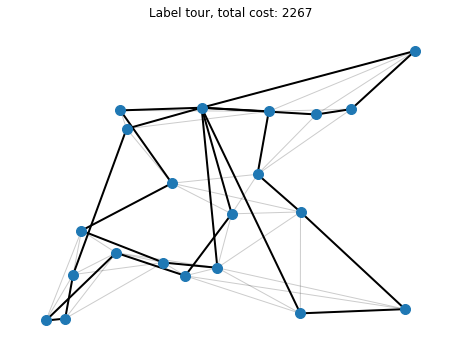

In [9]:
all_loc = np.concatenate((np.array(train_example['depot']).reshape(1, -1), np.array(train_example['loc'])), 0)
dist_matrix = squareform(pdist(all_loc))
G = nx.from_numpy_array(1-train_example['graph'].numpy())
G.remove_edges_from(nx.selfloop_edges(G))
pos = {i: coord for i, coord in enumerate(all_loc)}
# tour = train_example['tour_edges'].nonzero().numpy()
tour = [i for i in edges(train_example['adj'])]
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=100)
nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
nx.draw_networkx_edges(G, pos=pos, width=2, edgelist=tour, )
# tour = train_example['tour_nodes'].numpy()
# tour = np.append(tour, tour[0])
cost = train_example['total_dist']
plt.title(f'Label tour, total cost: {cost:.0f}')
plt.axis('off')
plt.show()

In [5]:
# model = NARModel(
#     problem=load_problem('cvrp'),
#     embedding_dim=100,
#     encoder_class=GNNEncoder,
#     n_encode_layers=2,
#     aggregation='max',
#     aggregation_graph='mean',
#     normalization='batch',
# )
model = pickle.load(open('/content/trained_models/vrp_solver1.sav', 'rb'))
model.to('cuda')

NARModel(
  (init_embed): Linear(in_features=3, out_features=100, bias=True)
  (embedder): GNNEncoder(
    (init_embed_edges): Embedding(2, 100)
    (layers): ModuleList(
      (0): GNNLayer(
        (U): Linear(in_features=100, out_features=100, bias=True)
        (V): Linear(in_features=100, out_features=100, bias=True)
        (A): Linear(in_features=100, out_features=100, bias=True)
        (B): Linear(in_features=100, out_features=100, bias=True)
        (C): Linear(in_features=100, out_features=100, bias=True)
        (norm_h): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (norm_e): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      )
      (1): GNNLayer(
        (U): Linear(in_features=100, out_features=100, bias=True)
        (V): Linear(in_features=100, out_features=100, bias=True)
        (A): Linear(in_features=100, out_features=100, bias=True)
        (B): Linear(in_features=100, out_features=1

In [6]:
optimizer = optim.Adam(params=model.parameters(), lr=0.0005)

In [7]:
class option():
    def __init__(self):
        self.run_name = 'train'
        self.epoch_size = 10000
        self.batch_size = 100
        self.no_tensorboard = True
        self.num_workers = 1
        self.no_progress_bar = False
        self.device = 'cuda'
        self.model = 'nar'
        self.accumulation_steps = 8
        self.max_grad_norm = 1
        self.log_step = 100
        self.checkpoint_epochs = 0
        self.n_epochs = 10
        self.save_dir = ""
opt = option()

# for epoch in range(opt.n_epochs):
#     train_epoch_sl(
#         model,
#         optimizer,
#         optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 1.0 ** epoch),
#         epoch,
#         train_dataset,
#         [val_dataset],
#         problem,
#         None,
#         opt
#     )

In [ ]:
# filename = 'finalized_model.sav'
# pickle.dump(model, open(filename, 'wb'))

Get test example

In [139]:
cvrplib = True

In [211]:
if cvrplib:
  from generator.parse_cvrplib import get_instance_from_CVRPLIB
  from problems.vrp.problem_vrp import nearest_neighbor_graph

  car_num = 4
  test_df, test_tour, test_paths  = get_instance_from_CVRPLIB()
  test_df['demand_norm'] = test_df['demand']/test_df['cap']
  test_df['latitude_norm'] = test_df['latitude']/100
  test_df['longitude_norm'] = test_df['longitude']/100
  x = torch.tensor(test_df[['latitude_norm', 'longitude_norm', 'demand_norm']].values).type(torch.float)
  graph = torch.ByteTensor(nearest_neighbor_graph(x, neighbors = 0.2, knn_strat = 'percentage'))  

else:
  car_num = 5
  test_example = val_dataset[15]
  with torch.no_grad():
    add_depot_demand = torch.cat((torch.zeros(1), test_example['demand']), 0)
    add_depot_loc = torch.cat((test_example['depot'][None, :], test_example['loc']), 0)
    x = torch.cat((add_depot_loc, add_depot_demand[:, None]), 1)
    graph = test_example['graph']

In [144]:
dist_matrix = squareform(pdist(x[:, :2].numpy()))
dist_matrix[(range(dist_matrix.shape[0])), (range(dist_matrix.shape[0]))] = np.inf

Make GNN prediction

In [145]:
nodes = x[None, ...].to('cuda')
graph = graph[None, ...].to('cuda')
model.eval()
with torch.no_grad():
    embeddings = model.embedder(model._init_embed(nodes), graph)
embeddings.shape

torch.Size([1, 101, 100])

In [146]:
with torch.no_grad():
    Ux = model.project_node_emb(embeddings)
    Gx = model.project_graph_emb(embeddings.mean(dim=1))
edge_embeddings = F.relu(Ux[:, :, None, :] + Ux[:, None, :, :] + Gx[:, None, None, :])

if model.mask_graph:
    edge_embeddings[graph[:, :, :, None].expand_as(edge_embeddings)] = 0

# Compute logits
with torch.no_grad():
    logits = model.edge_pred(edge_embeddings)  # B x V x V x 2
proba = F.softmax(logits, dim=3)
proba_adj = proba[0, :, :, 1].cpu().numpy()
proba_adj.shape

(101, 101)

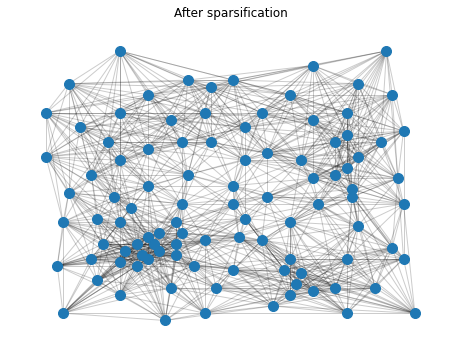

In [147]:
# G = nx.from_numpy_array(1-test_example['graph'].numpy())
G = nx.from_numpy_array(1-graph[0].cpu().numpy())
G.remove_edges_from(nx.selfloop_edges(G))
pos = {i: coord.numpy() for i, coord in enumerate(x[:, :2])}
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=100)
nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
plt.title('After sparsification')
plt.axis('off')
plt.show()

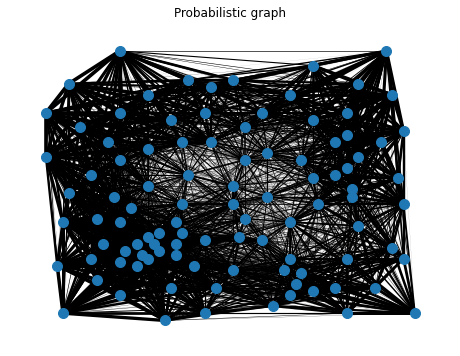

In [148]:
G = nx.from_numpy_array(proba_adj)
G.remove_edges_from(nx.selfloop_edges(G))
pos = {i: coord.numpy() for i, coord in enumerate(x[:, :2])}
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=100)
nx.draw_networkx_edges(G, pos=pos, width=[(G[u][v]['weight']*2)**2 for u,v in G.edges])
plt.title('Probabilistic graph')
plt.axis('off')
plt.show()

GNN model

In [210]:
def array_separator(arr):
  out = []
  out_temp = [0]
  for i in arr[1:]:
    if i == 0:
      if len(out_temp) != 1:
        out_temp.append(0)
        out.append(np.array(out_temp))
      out_temp = [0]
    else:
      out_temp.append(i)
  return np.array(out)

In [149]:
with torch.no_grad():
    _, _, tour = model.forward(nodes, graph, car_num, return_pi=True)
tour = tour.cpu().numpy()[0]
tour = np.append(tour, tour[0])

In [188]:
subtours

array([array([27, 69, 31, 64, 36, 49, 47, 46, 48, 19, 11, 62, 63, 90, 10, 32, 65,
              35, 34, 78,  9, 71, 66, 20, 51, 33, 29, 24])                       ,
       array([ 53,  58,   2,  57,  15,  43,  38,  44,  86,  17,  84,  45,   8,
               82,   7,  88,  52,  18,  60,   5,  61,  16,  14, 100,  91,  85,
               93,  98,  37,  42])                                            ,
       array([89,  6, 94, 97, 87, 95, 13, 92, 99, 59, 96, 83, 40, 26, 12, 80, 68,
              77,  3, 79, 81, 50, 76, 54, 55])                                   ],
      dtype=object)

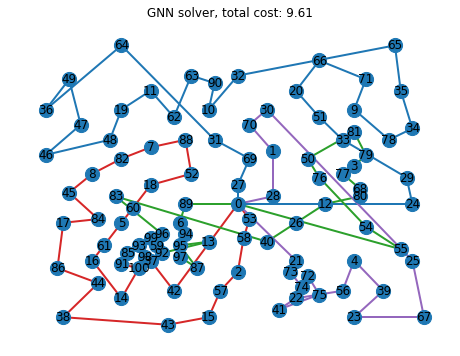

In [201]:
# G = nx.from_numpy_array(1-test_example['graph'].numpy())
G = nx.from_numpy_array(1-graph.cpu().numpy())
G.remove_edges_from(nx.selfloop_edges(G))
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=200)
# nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
subtours = array_separator(tour)
colors = ["tab:blue", "tab:red", "tab:green", "tab:purple", "tab:orange"]
for n, sub_t in enumerate(subtours):
  nx.draw_networkx_edges(G, pos=pos, width=2, edgelist=np.stack([sub_t[:-1], sub_t[1:]], axis=1), edge_color = colors[n])
nx.draw_networkx_labels(G, pos)
dist_matrix_ = dist_matrix.copy()
dist_matrix_[(range(dist_matrix_.shape[0])), (range(dist_matrix_.shape[0]))] = 0
cost = dist_matrix_[tour[:-1], tour[1:]].sum()
plt.title(f'GNN solver, total cost: {cost:.2f}')
plt.axis('off')
plt.show()


In [157]:
if cvrplib:
  temp = {i: 0 for i in range(test_df['cars'].max())}
  car = 0
  for i in tour[1:].astype(int):
      if i == 0:
          car+=1
      else:
          temp[car] += test_df['demand'][i]/test_df['cap'].max()
else:
  temp = {i: 0 for i in range(car_num)}
  car = 0
  for i in tour[1:].astype(int):
      if i == 0:
          car+=1/2
      else:
          temp[car] += test_example['demand'][i-1]
temp

{0: 0.9999999999999999, 1: 1.0000000000000002, 2: 0.99, 3: 0.655}

In [158]:
pd.DataFrame(tour).value_counts()

0      5
64     1
74     1
73     1
72     1
      ..
31     1
30     1
29     1
28     1
100    1
Length: 101, dtype: int64

OR-Tools

In [161]:
if cvrplib:
  from heurictics.op_tools import *
  from generator.distance_matrix import distance_function
  customer_count = 100+1

  distance = distance_function(test_df[['latitude', 'longitude']].values, is_coord = False)
  dist_matrix =pd.DataFrame(distance)
  dist_matrix.iloc[range(customer_count), range(customer_count)] = 0

  op_results = main(test_df, distance, cars = test_df['cars'].max(), cap = test_df['cap'].max())
  tour_sublist = np.array(list(op_results['paths'].values()))
  rtour = np.array([item for sublist in tour_sublist for item in sublist])
else:
  rtour = test_example['tour_nodes'].numpy()

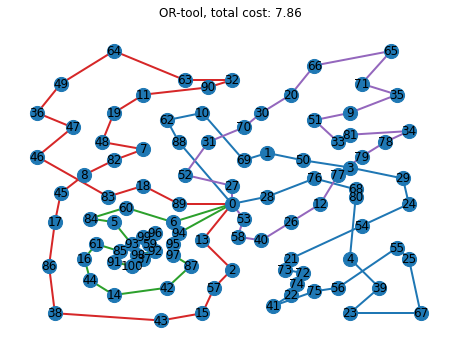

In [202]:
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=200)
# nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
subtours = array_separator(rtour)
colors = ["tab:blue", "tab:red", "tab:green", "tab:purple", "tab:orange"]
for n, sub_t in enumerate(subtours):
  nx.draw_networkx_edges(G, pos=pos, width=2, edgelist=np.stack([sub_t[:-1], sub_t[1:]], axis=1), edge_color = colors[n])
nx.draw_networkx_labels(G,pos)
cost = dist_matrix_[rtour[:-1].astype(int), rtour[1:].astype(int)].sum()
plt.title(f'OR-tool, total cost: {cost:.2f}')
plt.axis('off')
plt.show()

In [203]:
if cvrplib:
  temp = {i: 0 for i in range(test_df['cars'].max())}
  car = 0
  for i in rtour[1:].astype(int):
      if i == 0:
          car+=1/2
      else:
          temp[car] += test_df['demand'][i]/test_df['cap'].max()
else:
  temp = {i: 0 for i in range(car_num)}
  car = 0
  for i in rtour[1:].astype(int):
      if i == 0:
          car+=1/2
      else:
          temp[car] += test_example['demand'][i-1]
temp

{0: 0.9974999999999999, 1: 0.9049999999999998, 2: 0.87, 3: 0.8724999999999999}

Greedy solution

In [222]:
if not cvrplib:
  test_df_ = pd.DataFrame(torch.cat((test_example['depot'][None, : ], test_example['loc']), 0).numpy(), columns = ['latitude', 'longitude'])
  test_df_['demand'] = torch.cat((torch.zeros(1), test_example['demand']), 0).numpy()
  df_gr = test_df_.copy()
else:
  df_gr = test_df.copy()

In [223]:
from generator.distance_matrix import distance_function
customer_count = 100+1

distance = distance_function(df_gr[['latitude', 'longitude']].values, is_coord = False)
dist_matrix =pd.DataFrame(distance)
dist_matrix.iloc[range(customer_count), range(customer_count)] = np.inf

In [231]:
from heurictics.greedy import greedy_heurictics

greedy_results = greedy_heurictics(df_gr, dist_matrix, dim = customer_count, cap = df_gr['cap'].max(), k_nei = 3, iters = 100)

In [232]:
gr_tour = []
for p in greedy_results['paths'].values():
  for node in p: 
    gr_tour.append(node)

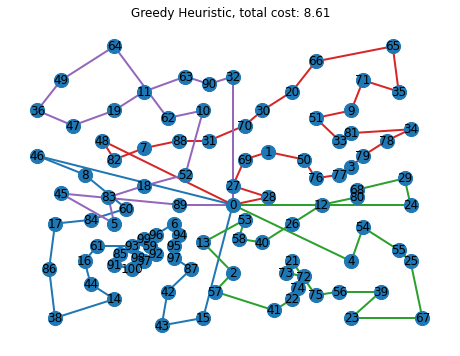

In [233]:
gr_tour = np.array(gr_tour)
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=200)
# nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
subtours = array_separator(gr_tour)
colors = ["tab:blue", "tab:red", "tab:green", "tab:purple", "tab:orange"]
for n, sub_t in enumerate(subtours):
  nx.draw_networkx_edges(G, pos=pos, width=2, edgelist=np.stack([sub_t[:-1], sub_t[1:]], axis=1), edge_color = colors[n])
nx.draw_networkx_labels(G,pos)
cost = dist_matrix_[gr_tour[:-1].astype(int), gr_tour[1:].astype(int)].sum()
plt.title(f'Greedy Heuristic, total cost: {cost:.2f}')
plt.axis('off')
plt.show()

Exact solution from CVRPLib (if exists)

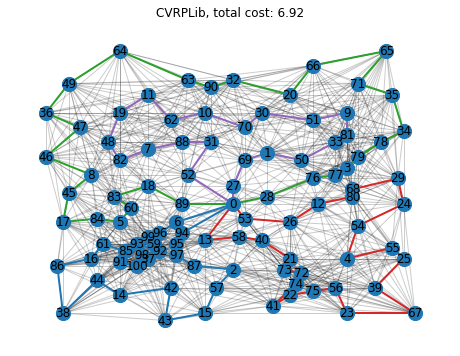

In [236]:
# G = nx.from_numpy_array(1-test_example['graph'].numpy())
G = nx.from_numpy_array(1-graph.cpu().numpy())
G.remove_edges_from(nx.selfloop_edges(G))
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=200)
nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
subtours = array_separator(test_tour)
colors = ["tab:blue", "tab:red", "tab:green", "tab:purple", "tab:orange"]
for n, sub_t in enumerate(subtours):
  nx.draw_networkx_edges(G, pos=pos, width=2, edgelist=np.stack([sub_t[:-1], sub_t[1:]], axis=1), edge_color = colors[n])
nx.draw_networkx_labels(G, pos)
dist_matrix = squareform(pdist(x[:, :2].numpy()))
dist_matrix[(range(dist_matrix.shape[0])), (range(dist_matrix.shape[0]))] = np.inf
dist_matrix_ = dist_matrix.copy()
dist_matrix_[(range(dist_matrix_.shape[0])), (range(dist_matrix_.shape[0]))] = 0
cost = dist_matrix_[test_tour[:-1], test_tour[1:]].sum()
plt.title(f'CVRPLib, total cost: {cost:.2f}')
plt.axis('off')
plt.show()


In [238]:
if cvrplib:
  temp = {i: 0 for i in range(test_df['cars'].max())}
  car = 0
  for i in test_tour[1:].astype(int):
      if i == 0:
          car+=1/2
      else:
          temp[car] += test_df['demand'][i]/test_df['cap'].max()
else:
  temp = {i: 0 for i in range(car_num)}
  car = 0
  for i in test_tour[1:].astype(int):
      if i == 0:
          car+=1/2
      else:
          temp[car] += test_example['demand'][i-1]
temp

{0: 0.9800000000000001, 1: 0.96, 2: 0.9549999999999997, 3: 0.7499999999999999}